In [ ]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
  Attempting uninstall: neurogym
    Found existing installation: neurogym 0.0.2
    Uninstalling neurogym-0.0.2:
      Successfully uninstalled neurogym-0.0.2
  Running setup.py develop for neurogym


In [ ]:
# @title importing neurogym
import neurogym as ngym

# Canned environment from neurogym
# Copy the name of the Perceptual Decision Making environment from here: https://neurogym.github.io/envs/index.html
task_name = 'DelayComparison-v0'
# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [ ]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.nn import init
from torch.nn import functional as F
import math
import logging

In [ ]:
# Make a LSTM, with input_size =10,
# hidden_size is the number of hidden neurons = 20
# number of layers = 2
# checkout the pytorch LSTM documentation
rnn = nn.LSTM(input_size = 10, hidden_size = 20, num_layers = 2)

# Generate some mock inputs
input = torch.randn(5, 3, 10)  # The arguments represent (Sequence Length, Batch Size, Input Size). Typically, in neuroscience,
# sequence length would correspond to time points in the time series, Batch size corresponds to the number of trials and
# input size corresponds to the dimension of the input (ie., the number of neurons or channels you're collecting data from)
output, (hn, cn) = rnn(input)

print('Output shape is (SeqLen, BatchSize, HiddenSize):', output.shape)

Output shape is (SeqLen, BatchSize, HiddenSize): torch.Size([5, 3, 20])


In [ ]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        #implement how much the previous hidden layer activity should be maintained in the new activity
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add a Linear output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [ ]:
batch_size = 16
seq_len = 20  # sequence length
input_size = 5  # input dimension

# Make some random inputs
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Make network of 100 hidden units and 10 output units
rnn = RNNNet(input_size=input_size, hidden_size=100,output_size=10)

# Run the sequence through the network
out, rnn_output = rnn(input_rnn)

print('Input of shape =', input_rnn.shape)
print('Output of shape =', out.shape)

Input of shape = torch.Size([20, 16, 5])
Output of shape = torch.Size([20, 16, 10])


In [ ]:

%%capture
# @title import the task from the neurogym library

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'DelayComparison-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=2, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 0.1479
Step 400, Loss 0.0720
Step 600, Loss 0.0407
Step 800, Loss 0.0333
Step 1000, Loss 0.0291
Step 1200, Loss 0.0280
Step 1400, Loss 0.0266
Step 1600, Loss 0.0272
Step 1800, Loss 0.0259
Step 2000, Loss 0.0255
Step 2200, Loss 0.0254
Step 2400, Loss 0.0253
Step 2600, Loss 0.0253
Step 2800, Loss 0.0247
Step 3000, Loss 0.0248
Step 3200, Loss 0.0248
Step 3400, Loss 0.0249
Step 3600, Loss 0.0238
Step 3800, Loss 0.0252
Step 4000, Loss 0.0241
Step 4200, Loss 0.0329
Step 4400, Loss 0.0306
Step 4600, Loss 0.0266
Step 4800, Loss 0.0250
Step 5000, Loss 0.0243


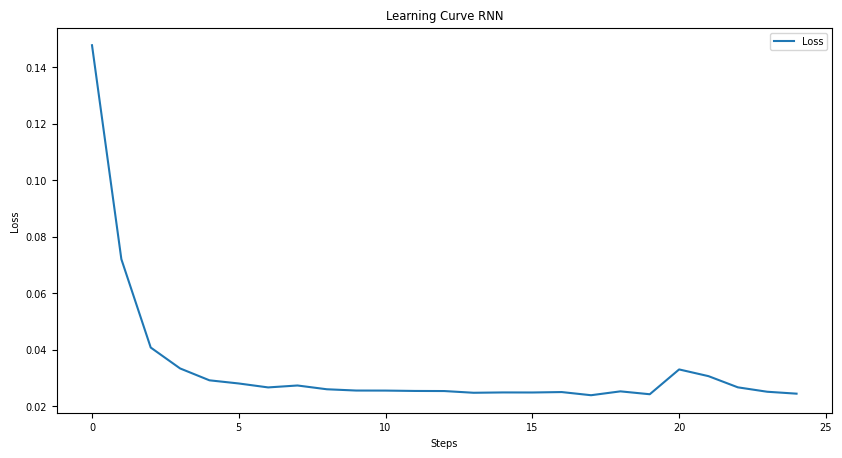

In [ ]:
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
RNN_net = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt)
print(RNN_net)

# Use Adam optimizer
optimizer = optim.Adam(RNN_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = RNN_net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve RNN")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information

num_trial = 50
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = RNN_net(inputs)

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]
    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})

# Print information for sample trials
for i in range(5):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Trial  0 {'ground_truth': 2, 'vpair': (18, 10), 'v1': 10, 'v2': 18, 'correct': False}
Trial  1 {'ground_truth': 1, 'vpair': (18, 10), 'v1': 18, 'v2': 10, 'correct': True}
Trial  2 {'ground_truth': 2, 'vpair': (26, 18), 'v1': 18, 'v2': 26, 'correct': False}
Trial  3 {'ground_truth': 2, 'vpair': (30, 22), 'v1': 22, 'v2': 30, 'correct': True}
Trial  4 {'ground_truth': 2, 'vpair': (18, 10), 'v1': 10, 'v2': 18, 'correct': False}
Average performance 0.62


Text(0, 0.5, 'Activity')

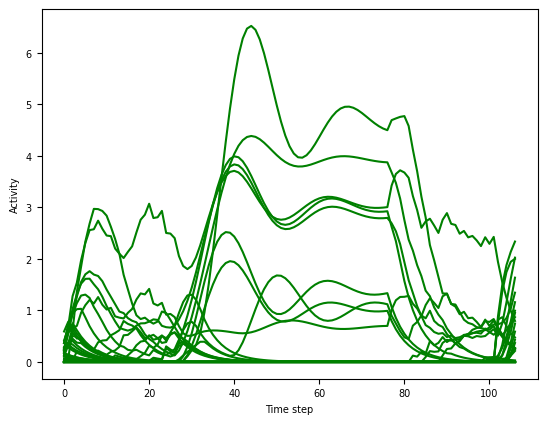

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

input_size = RNN_net.rnn.input_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial], color='green', label='Neurons')
plt.xlabel('Time step')
plt.ylabel('Activity')

In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = RNN_net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    rnn_activity = rnn_activity[env.start_ind['stimulus1']: env.end_ind['stimulus1']]
    # Set timing back to the modified timing
    stim_activity[env.trial['ground_truth']-1].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.672


In [ ]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

ind_sort = np.argsort(selectivity)


Text(0.5, 1.0, 'Network connectivity')

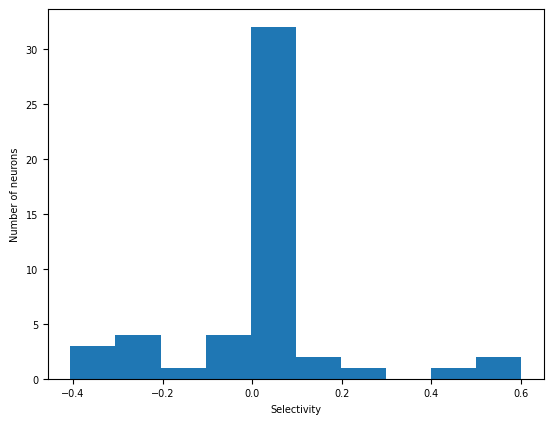

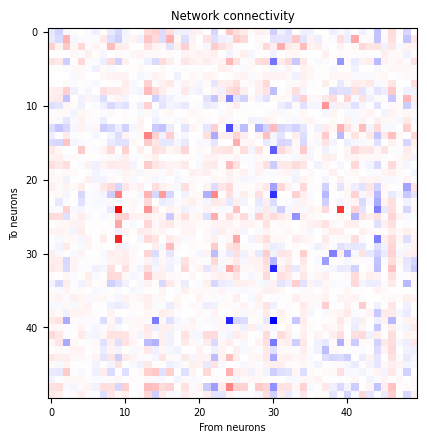

In [ ]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = RNN_net.rnn.h2h.weight.detach().numpy()
# Sort by selectivity
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

Shape of the neural activity (Time points, Neurons): (65000, 50)
Shape of the projected activity (Time points, PCs): (65000, 2)


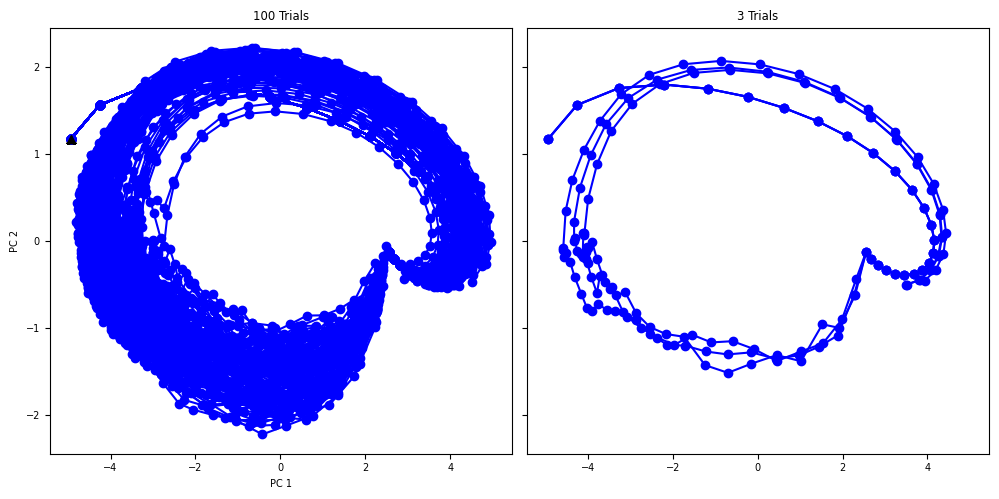

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D) - hint ".transform" could he helpful
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()


In [ ]:
# Path to the uploaded file
!unzip /content/fixed-point-finder-master.zip -d /content/

# Navigate to the extracted directory
%cd /content/fixed-point-finder-master

# Install required dependencies from the requirements file
!pip install -r requirements-torch

# Install dependencies
!pip install numpy==1.24.3 scikit-learn==1.2.2 matplotlib==3.7.1 torch==1.12.1

unzip:  cannot find or open /content/fixed-point-finder-master.zip, /content/fixed-point-finder-master.zip.zip or /content/fixed-point-finder-master.zip.ZIP.
[Errno 2] No such file or directory: '/content/fixed-point-finder-master'
/content/neurogym
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements-torch'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninst

In [ ]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN

In [ ]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [ ]:
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(RNN_net.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, RNN_net.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
inputs = torch.zeros(10, RNN_net.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Find fixed points (CHeck FixedPointFinder documentation)
fixed_points_result = finder.find_fixed_points(initial_states= init_hidden_np, inputs= inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		3708 iters
		q = 1.52e-12 +/- 4.27e-12
		dq = 3.55e-15 +/- 8.56e-15
		learning rate = 1.61e-06
		avg iter time = 8.79e-04 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



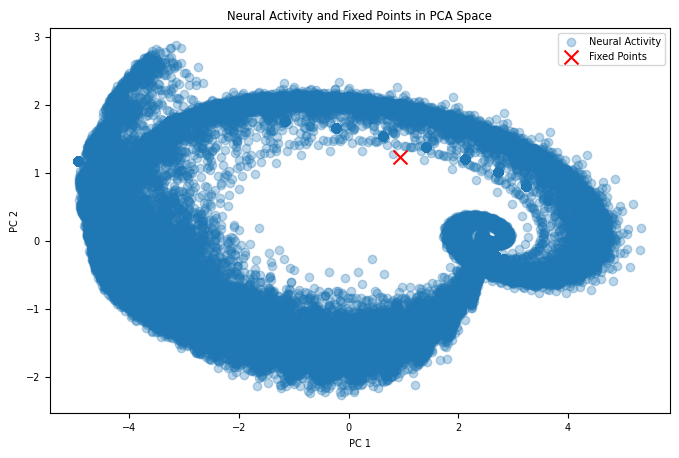

In [ ]:
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space")
plt.legend()
plt.show()



Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 2.83e-12 +/- 3.44e-13
		dq = 1.53e-13 +/- 2.30e-13
		learning rate = 1.97e-07
		avg iter time = 8.77e-04 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		851 iters
		q = 7.45e-13 +/- 1.31e-13
		dq = 5.52e-13 +/- 7.36e-13
		learnin

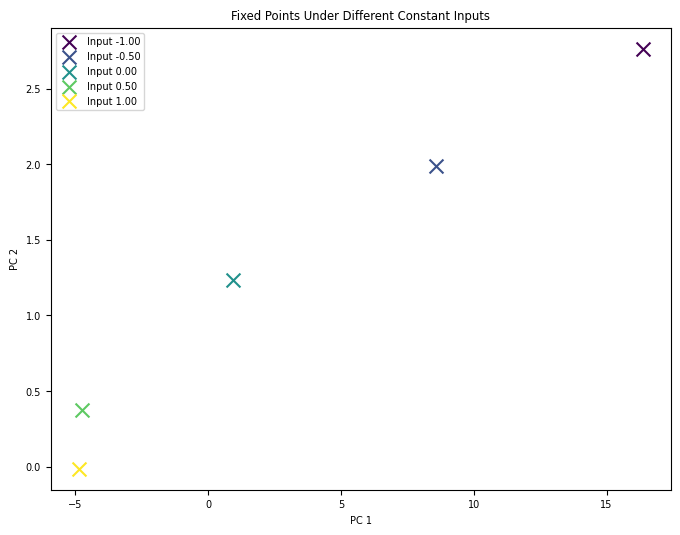

In [ ]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  # 5 different input values
fixed_points_by_input = []

for input_val in input_values:
    # Prepare constant input
    inputs_np = np.full((10, RNN_net.rnn.input_size), input_val)  # Batch of 10 initial conditions

    # Use the same initial conditions as before
    init_hidden_np = initial_conditions.cpu().numpy()

    # Find fixed points with the current input
    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

# Plot fixed points for different inputs
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    # Project fixed points into PCA space
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()